In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

alpha = 0.05

def standardize(X):
    return (X - X.mean()) / X.std()

### Data Import & EDA

In [2]:
data = pd.read_csv('data.csv')
data.head(10)

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile,CES 4.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,2780,Fresno,93706,Fresno,-119.781696,36.709695,93.18,100.00,95-100% (highest scores),...,79.37,76.0,98.92,12.8,93.83,30.3,91.04,93.16,9.66,99.72
1,6077000700,4680,San Joaquin,95206,Stockton,-121.287873,37.943173,86.65,99.99,95-100% (highest scores),...,95.53,73.2,98.39,19.8,99.21,31.2,92.28,93.17,9.66,99.74
2,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,99.97,95-100% (highest scores),...,81.55,62.6,93.39,6.4,61.53,20.3,63.97,83.75,8.69,95.79
3,6019000700,3664,Fresno,93706,Fresno,-119.827707,36.734535,81.33,99.96,95-100% (highest scores),...,78.71,65.7,95.35,15.7,97.35,35.4,96.41,94.64,9.82,99.89
4,6019000200,2689,Fresno,93706,Fresno,-119.805504,36.735491,80.75,99.95,95-100% (highest scores),...,86.56,72.7,98.30,13.7,95.29,32.7,94.16,95.40,9.90,99.95
5,6037542402,3306,Los Angeles,90221,Compton,-118.212413,33.881969,80.71,99.94,95-100% (highest scores),...,NaN,43.5,74.05,9.3,83.22,23.7,76.35,83.37,8.65,95.46
6,6019001000,4255,Fresno,93706,Fresno,-119.804314,36.697751,80.55,99.92,95-100% (highest scores),...,88.70,79.5,99.41,15.4,97.14,33.3,94.83,95.84,9.94,99.99
7,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,99.91,95-100% (highest scores),...,60.62,56.8,88.92,12.6,93.49,29.6,89.84,85.44,8.86,96.90
8,6019001202,4561,Fresno,93725,Unincorporated Fresno County area,-119.741028,36.702685,79.17,99.90,95-100% (highest scores),...,89.62,72.2,98.12,16.3,97.90,30.8,91.76,87.24,9.05,98.05
9,6077000100,3688,San Joaquin,95202,Stockton,-121.285363,37.953996,77.87,99.89,95-100% (highest scores),...,91.39,78.8,99.31,14.6,96.46,33.1,94.64,95.83,9.94,99.97


The purpose of adding the code below is because some of the variables have spaces, which the sms library cannot read as a formula.

In [3]:
def fill_space(s):
    return s.replace(" ", "_").replace(".", "")

data_copy = data.copy()
for feature in data.columns:
    new_feature = fill_space(feature)
    if new_feature != feature:
        data[new_feature] = data[feature]
        data_copy[new_feature] = data_copy[feature]
        data = data.drop(columns=[feature])
        data_copy = data_copy.drop(columns=[feature])
    if 'Pctl' in feature:
        data_copy = data_copy.drop(columns=[new_feature])


We drop the education percentile variable because it carries a significant amount of information concering the education variable itself. 

In [4]:
data = data.drop(columns=['Education_Pctl'])
data.columns

Index(['ZIP', 'Longitude', 'Latitude', 'Ozone', 'Lead', 'Pesticides',
       'Traffic', 'Asthma', 'Education', 'Poverty', 'Unemployment',
       'Census_Tract', 'Total_Population', 'California_County',
       'Approximate_Location', 'CES_40_Score', 'CES_40_Percentile',
       'CES_40_Percentile_Range', 'Ozone_Pctl', 'PM25', 'PM25_Pctl',
       'Diesel_PM', 'Diesel_PM_Pctl', 'Drinking_Water', 'Drinking_Water_Pctl',
       'Lead_Pctl', 'Pesticides_Pctl', 'Tox_Release', 'Tox_Release_Pctl',
       'Traffic_Pctl', 'Cleanup_Sites', 'Cleanup_Sites_Pctl',
       'Groundwater_Threats', 'Groundwater_Threats_Pctl', 'Haz_Waste',
       'Haz_Waste_Pctl', 'Imp_Water_Bodies', 'Imp_Water_Bodies_Pctl',
       'Solid_Waste', 'Solid_Waste_Pctl', 'Pollution_Burden',
       'Pollution_Burden_Score', 'Pollution_Burden_Pctl', 'Asthma_Pctl',
       'Low_Birth_Weight', 'Low_Birth_Weight_Pctl', 'Cardiovascular_Disease',
       'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation',
       'Linguistic_Isolation_P

## Selecting Columns
We will focus primary on poverty level and try to find variables which we believe will correlate most with poverty level. Originally selected the following
-   Total Population
-   California County
-   Unemployment
-   Zip code
-   Poverty Percentile 
-   Lead
-   PM2.5 Pctl

But pivoted to the following

-   Total Population
-   California County
-   Unemployment
-   Zip code
-   Poverty 
-   Lead
-   PM2.5
  
The reasoning behind these choices was that if the data is already standardized it will be difficult to observed the differences between the two counties in exploration. Moreover, we swapped education and poverty because we instead want to predict education.

In [5]:
clean = data[['California_County', 'Poverty', 'Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Education']].sort_values('Poverty', ascending=False)

columns = ['Poverty', 'Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Education']

### Distribution of `Poverty`

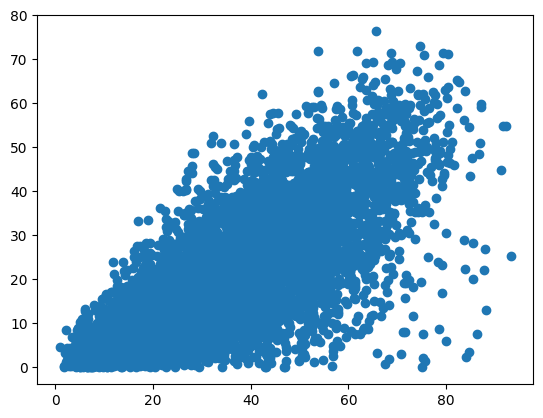

In [6]:
plt.scatter(x=clean['Poverty'],y=clean['Education'])

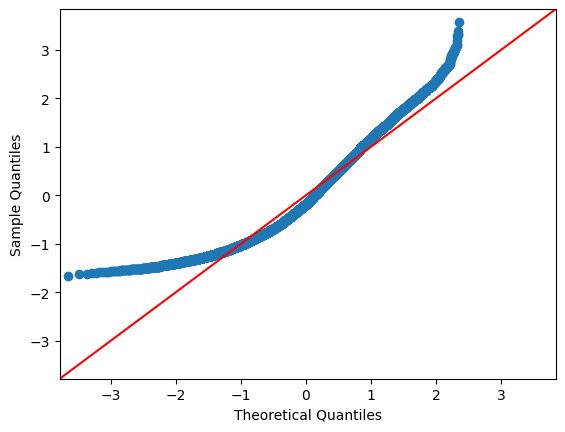

In [7]:
hide = sm.qqplot((standardize(clean['Poverty'])), stats.norm, line='45')

<Axes: xlabel='Poverty', ylabel='Count'>

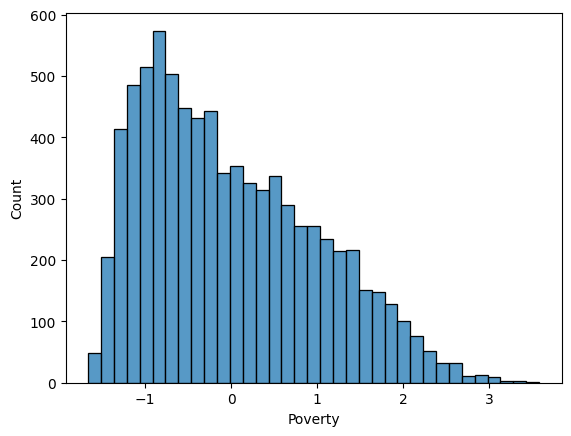

In [8]:
sns.histplot(data=standardize(data['Poverty']))

### Distribution of `Education`

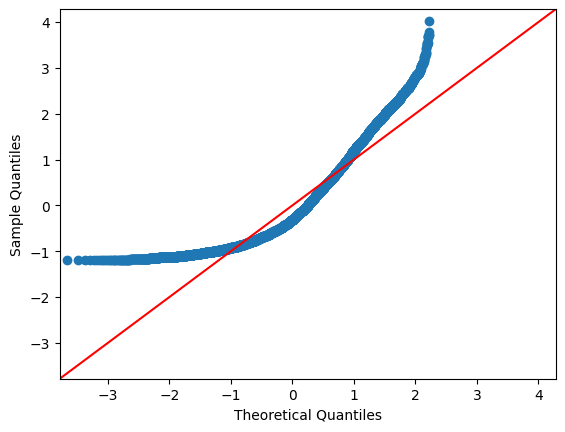

In [9]:
hide = sm.qqplot((standardize(data['Education'])), stats.norm, line='45')

<Axes: xlabel='Education', ylabel='Count'>

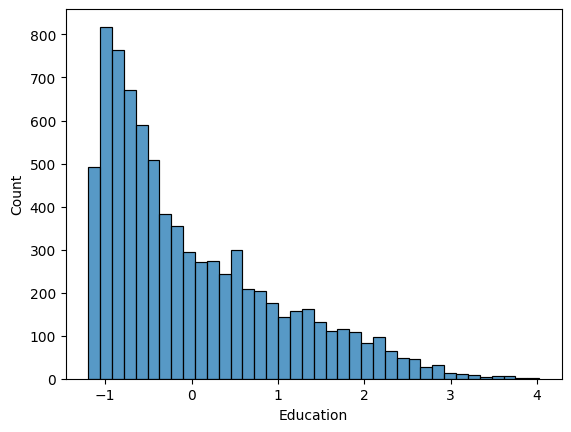

In [10]:
sns.histplot(data=standardize(data['Education']))

### Basic OLS Model

In [11]:
model_clean = smf.ols('Poverty ~ Education', clean).fit()
print(model_clean.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.2554      0.198     72.054      0.000      13.868      14.643
Education      0.9787      0.009    112.583      0.000       0.962       0.996


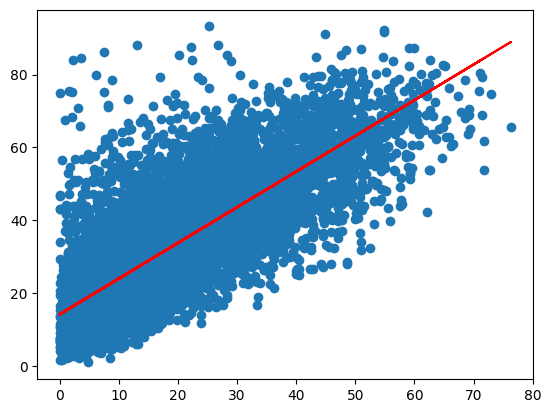

In [12]:
plt.scatter(clean['Education'], clean['Poverty'])
plt.plot(clean['Education'], model_clean.predict(clean), color='red')

Missingness?: Dropping rows where education is missing. Negligible data loss. 54 from ~2950 rows.

Five Assumptions For Lin. Regression:
1. Linear
2. Independence
3. Heteroscedasticity
4. Normally Distributed Error
5. Completeness

Our model to test:

$\hat{\text{Education}} = \text{Variables}$

The most highly correlated variables were:

- Lead: 0.64
- Pollution Burden: 0.44
- Asthma: 0.44
- Linguistic Iso.: 0.71
- Poverty: 0.78
- Unemployment: 0.39
- Housing Burden: 0.53
- Cardiovascular Disease: 0.47

But to reduce multicollinearity we narrowed it down to five variables:

- Lead: 0.64
- Pollution Burden: 0.44
- Asthma: 0.44
- Linguistic Isolation: 0.71
- Poverty: 0.78

In [13]:
def present(feature_x, feature_y):
    plt.scatter(x=clean[feature_x],y=clean[feature_y])

<Axes: >

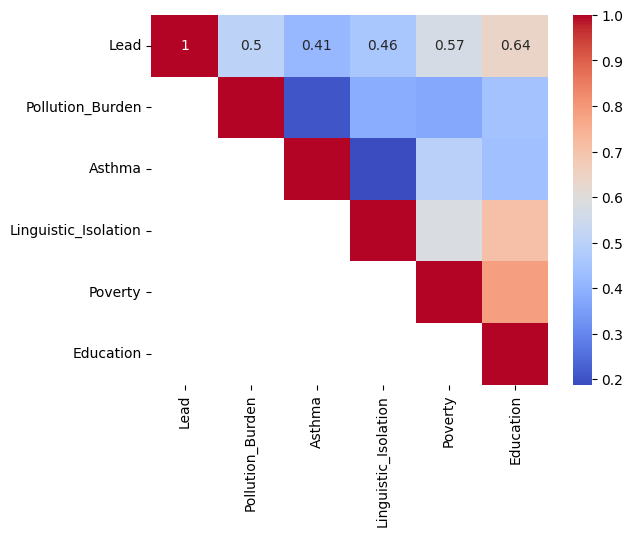

In [79]:
drop_data = data[['Lead', 'Pollution_Burden', 'Asthma', 'Linguistic_Isolation', 'Poverty', 'Education']]
variables = drop_data.columns
corr_table = drop_data[variables].corr() 
sns.heatmap(corr_table, annot=True, cmap='coolwarm', mask=np.tril(corr_table, k=-1))

### Shapiro-Wilk Test

We can run the shapiro-wilk test to check if our data is normally distributed. The anatomy of the test is the following 
$$
\begin{aligned}
H_{0}: X_{1},X_{2},...,,X_{n} \sim N(\mu,\sigma^{2}) \text{ for some } \mu \in \mathbb{R}, \sigma > 0 \\ 
H_{a}: X_{1},X_{2},...,,X_{n} \ne N(\mu,\sigma^{2}) \text{ for some } \mu \in \mathbb{R}, \sigma > 0 
\end{aligned}
$$

#### Poverty Shapiro-Wilk test

In [15]:
poverty_pval = stats.shapiro(clean['Poverty']).pvalue
if poverty_pval < alpha:
    print("REJECT NULL")
else:
    print("FAIL TO REJECT NULL")

FAIL TO REJECT NULL


C:\Users\nicks\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


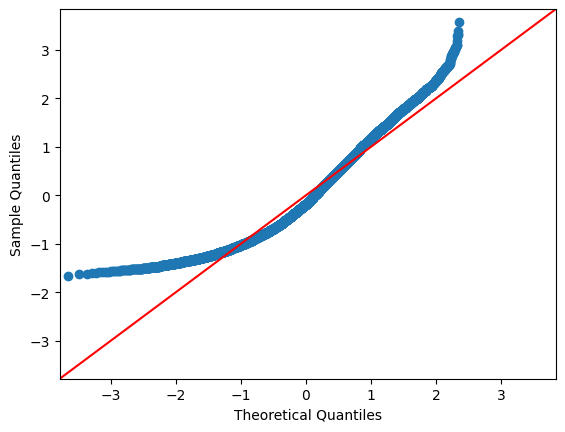

In [16]:
hide = sm.qqplot((clean['Poverty'] - clean['Poverty'].mean()) / np.std(clean['Poverty']), stats.norm, line='45')

>There seems to be evidence that the feature `Poverty` follows a normal distribution for an alpha level of .05

### Complete OLS Model

In [17]:
model = smf.ols('Education ~ Poverty + Lead + Asthma + Linguistic_Isolation + Pollution_Burden', clean).fit()

# Regression Assumptions

### Independence of residuals

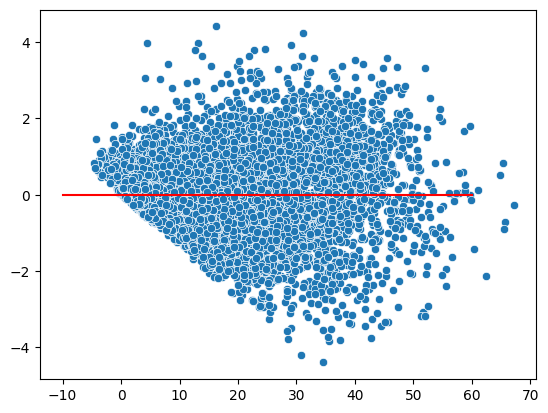

In [18]:
sns.scatterplot(x=model.fittedvalues, y=standardize(model.resid))
plt.plot(np.linspace(-10, 60, 100), np.zeros(100), 'r')

### Normality of Residuals

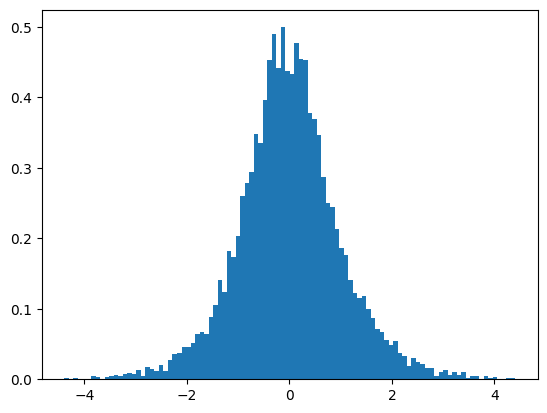

In [19]:
hide = plt.hist(standardize(model.resid), bins=100, density=True)

In [20]:
residuals_pvalue = stats.shapiro(standardize(model.resid)).pvalue
if residuals_pvalue < alpha:
    print("REJECT NULL")
else:
    print("FAIL TO REJECT NULL")

REJECT NULL


C:\Users\nicks\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


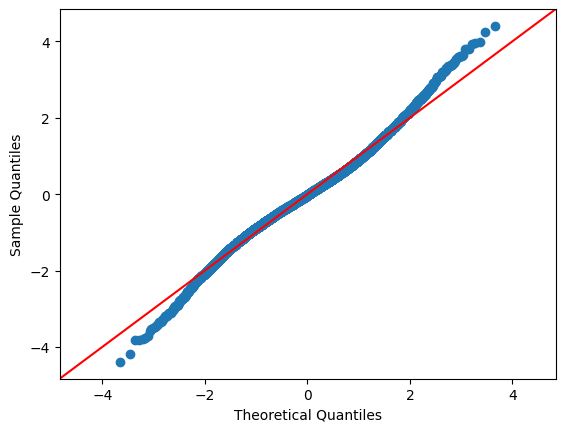

In [21]:
qq = sm.qqplot(standardize(model.resid), stats.norm, line='45')

### Check for Independence

<BarContainer object of 21 artists>

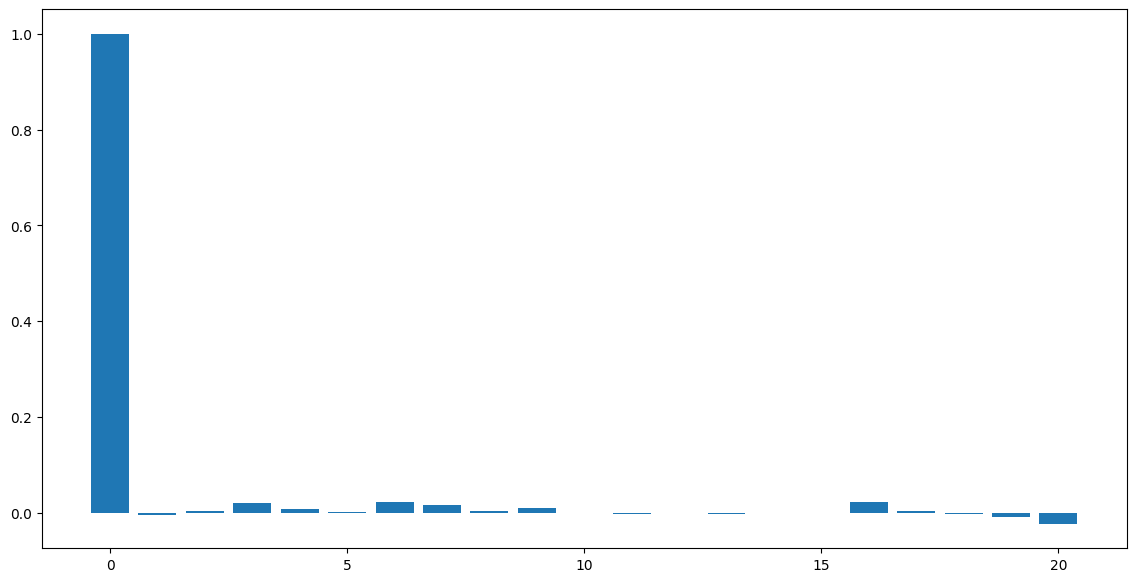

In [22]:
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model.resid, nlags=lags))

### Heteroscedasticity


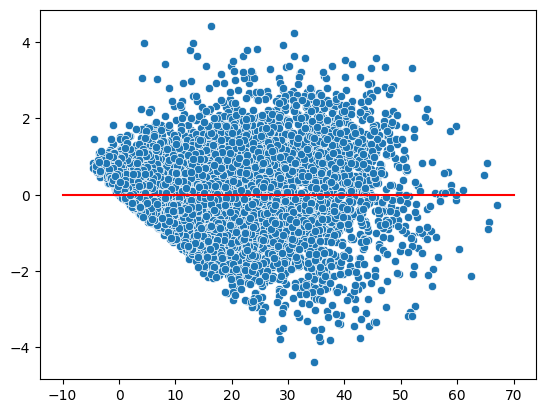

In [23]:
sns.scatterplot(x=model.predict(clean[columns]), y=standardize(model.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

### Completeness

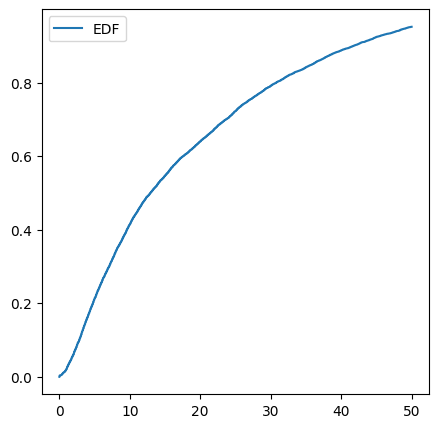

In [24]:
xrange = np.linspace(0, 50, 1000)
sd_la_ecdf= np.array([sum(clean['Education'] < x) for x in xrange]) / len(clean)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(xrange, sd_la_ecdf, label='EDF')
ax.legend()

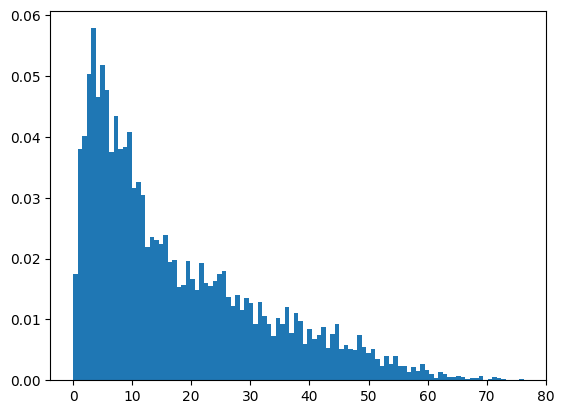

In [25]:
hide = plt.hist(clean['Education'], bins=100, density=True)

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     4626.
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:22:45   Log-Likelihood:                -26177.
No. Observations:                7672   AIC:                         5.237e+04
Df Residuals:                    7666   BIC:                         5.241e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.3005      0.310    -26.770      0.000      -8.908      -7.693
Poverty                  0.3413      0.007     49.675      0.000       0.328       0.355
Lead                     0.1217      0.005     24.751      0.000       0.112       0.131
Asthma                   0.0363      0.003     10.932      0.000       0.030       0.043
Linguistic_Isolation     0.5308      0.011     46.255      0.000       0.508       0.553
Pollution_Burden         0.0496      0.008      6.333      0.000       0.034       0.065
==============================================================================
Omnibus:                      189.152   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.103
Skew:                           0.113   Prob(JB):                     8.86e-90
Kurtosis:                       4.110   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Feature Selection
Instead of using our intuition, we turned to more established techniques for selecting the most meaningful covariates.

In [27]:
# REMOVING REDUNDANT COLUMNS

old_columns = ['ZIP', 'Longitude', 'Latitude', 'Ozone', 'Lead', 'Pesticides',
       'Traffic', 'Asthma', 'Education', 'Poverty', 'Unemployment',
       'Census_Tract', 'Total_Population', 'California_County',
       'Approximate_Location', 'CES_40_Score', 'CES_40_Percentile',
       'CES_40_Percentile_Range', 'Ozone_Pctl', 'PM25', 'PM25_Pctl',
       'Diesel_PM', 'Diesel_PM_Pctl', 'Drinking_Water', 'Drinking_Water_Pctl',
       'Lead_Pctl', 'Pesticides_Pctl', 'Tox_Release', 'Tox_Release_Pctl',
       'Traffic_Pctl', 'Cleanup_Sites', 'Cleanup_Sites_Pctl',
       'Groundwater_Threats', 'Groundwater_Threats_Pctl', 'Haz_Waste',
       'Haz_Waste_Pctl', 'Imp_Water_Bodies', 'Imp_Water_Bodies_Pctl',
       'Solid_Waste', 'Solid_Waste_Pctl', 'Pollution_Burden',
       'Pollution_Burden_Score', 'Pollution_Burden_Pctl', 'Asthma_Pctl',
       'Low_Birth_Weight', 'Low_Birth_Weight_Pctl', 'Cardiovascular_Disease',
       'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation',
       'Linguistic_Isolation_Pctl', 'Poverty_Pctl', 'Unemployment_Pctl',
       'Housing_Burden', 'Housing_Burden_Pctl', 'Pop_Char_', 'Pop_Char_Score',
       'Pop_Char_Pctl']

to_remove = []
for column in old_columns:
    if "CES_40" in column:
        to_remove.append(column)
    elif "Pollution_Burden" in column:
        to_remove.append(column)
    elif "Pop_Char" in column:
        to_remove.append(column)
    elif "Pctl" in column:
        to_remove.append(column)
        
new_columns = list(set(old_columns) - set(to_remove))
new_columns

['California_County',
 'Total_Population',
 'Groundwater_Threats',
 'Unemployment',
 'Tox_Release',
 'Imp_Water_Bodies',
 'Census_Tract',
 'Solid_Waste',
 'Traffic',
 'Asthma',
 'Lead',
 'Haz_Waste',
 'Latitude',
 'Ozone',
 'PM25',
 'Low_Birth_Weight',
 'Linguistic_Isolation',
 'ZIP',
 'Housing_Burden',
 'Diesel_PM',
 'Cleanup_Sites',
 'Poverty',
 'Education',
 'Cardiovascular_Disease',
 'Longitude',
 'Pesticides',
 'Drinking_Water',
 'Approximate_Location']

In [28]:
# NEW DATAFRAME
selection_data = data[new_columns]
selection_data.columns

Index(['California_County', 'Total_Population', 'Groundwater_Threats',
       'Unemployment', 'Tox_Release', 'Imp_Water_Bodies', 'Census_Tract',
       'Solid_Waste', 'Traffic', 'Asthma', 'Lead', 'Haz_Waste', 'Latitude',
       'Ozone', 'PM25', 'Low_Birth_Weight', 'Linguistic_Isolation', 'ZIP',
       'Housing_Burden', 'Diesel_PM', 'Cleanup_Sites', 'Poverty', 'Education',
       'Cardiovascular_Disease', 'Longitude', 'Pesticides', 'Drinking_Water',
       'Approximate_Location'],
      dtype='object')

In [29]:
criterion = lambda formula, df: smf.ols(formula, data=selection_data).fit().bic

def add(df, selected_columns, columns, criterion, response='y'):
    best_criterion = np.inf
    best_column = None
    for column in columns - selected_columns:
        new_columns = selected_columns.union({column})
        formula = f'{response} ~ {" + ".join(new_columns)}'
        current_criterion = criterion(formula, df)
        if current_criterion < best_criterion:
            best_criterion = current_criterion
            best_column = column
    print(best_column)
    return selected_columns.union({best_column}), best_criterion

def forward(df, criterion, response='y'):
    selected_columns = set()
    columns = set(df.columns.drop(response))
    best_criterion = np.inf
    while len(selected_columns) < len(columns):
        potential_columns, current_criterion = add(df, selected_columns, columns, criterion, response)
        if current_criterion > best_criterion:
            break
        else:
            selected_columns = potential_columns
            best_criterion = current_criterion
            print(f'Criterion: {best_criterion}')
    return selected_columns

forward_vars = forward(selection_data, criterion, response='Education')
forward_vars

Poverty
Criterion: 57280.9320387672
Linguistic_Isolation
Criterion: 53485.54569503719
Unemployment
Criterion: 52041.31879448832
Lead
Criterion: 51141.003631988024
Cardiovascular_Disease
Criterion: 50564.49672135168
Low_Birth_Weight
Criterion: 50040.063545273115
California_County
Criterion: 49762.816247309136
Housing_Burden
Criterion: 49537.03919866663
Traffic
Criterion: 49405.18492591479
Total_Population
Criterion: 49353.74151121114
Pesticides
Criterion: 49327.35496608434
Solid_Waste
Criterion: 49305.45456261674
Tox_Release
Criterion: 49291.1298005717
Ozone
Criterion: 49253.26599445678
Longitude
Criterion: 49240.14154416418
Latitude
Criterion: 49218.16663756602
Census_Tract
Criterion: 49194.57683604311
Groundwater_Threats
Criterion: 49183.87254240522
Drinking_Water
Criterion: 49179.369281687534
Haz_Waste
Criterion: 49175.88363522878
Diesel_PM


{'California_County',
 'Cardiovascular_Disease',
 'Census_Tract',
 'Drinking_Water',
 'Groundwater_Threats',
 'Haz_Waste',
 'Housing_Burden',
 'Latitude',
 'Lead',
 'Linguistic_Isolation',
 'Longitude',
 'Low_Birth_Weight',
 'Ozone',
 'Pesticides',
 'Poverty',
 'Solid_Waste',
 'Total_Population',
 'Tox_Release',
 'Traffic',
 'Unemployment'}

In [30]:
# EXCLUDED VARIABLES
set(new_columns) - set(forward_vars)

{'Approximate_Location',
 'Asthma',
 'Cleanup_Sites',
 'Diesel_PM',
 'Education',
 'Imp_Water_Bodies',
 'PM25',
 'ZIP'}

In [31]:
true_model_formula = 'Education ~ ' + ' + '.join(forward_vars)
model_forward = smf.ols(true_model_formula, data).fit()
model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     419.2
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:23:52   Log-Likelihood:                -24267.
No. Observations:                7355   AIC:                         4.868e+04
Df Residuals:                    7283   BIC:                         4.918e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -2.397e+04   4314.653     -5.555      0.000   -3.24e+04   -1.55e+04
California_County[T.Alpine ]         -1.153e-05   2.07e-06     -5.562      0.000   -1.56e-05   -7.46e-06
California_County[T.Amador ]            -8.3036      3.431     -2.420      0.016     -15.030      -1.577
California_County[T.Butte ]            -19.7156      4.161     -4.738      0.000     -27.872     -11.559
California_County[T.Calaveras ]        -26.8332      5.983     -4.485      0.000     -38.561     -15.106
California_County[T.Colusa ]           -29.2418      7.453     -3.924      0.000     -43.851     -14.633
California_County[T.Contra Costa]      -45.3302      8.562     -5.295      0.000     -62.114     -28.547
California_County[T.Del Norte]       -2.155e-10   4.02e-11     -5.365      0.000   -2.94e-10   -1.37e-10
California_County[T.El Dorado]         -53.0439     11.176     -4.746      0.000     -74.953     -31.135
California_County[T.Fresno ]           -68.4939     12.768     -5.365      0.000     -93.522     -43.465
California_County[T.Glenn ]            -70.6232     14.311     -4.935      0.000     -98.677     -42.570
California_County[T.Humboldt ]         -86.4415     15.513     -5.572      0.000    -116.851     -56.032
California_County[T.Imperial ]         -99.1200     17.431     -5.687      0.000    -133.289     -64.951
California_County[T.Inyo ]             -96.6997     18.588     -5.202      0.000    -133.138     -60.261
California_County[T.Kern ]            -113.2333     20.050     -5.647      0.000    -152.537     -73.929
California_County[T.Kings ]           -123.4207     21.409     -5.765      0.000    -165.388     -81.453
California_County[T.Lake ]            -122.2848     22.747     -5.376      0.000    -166.876     -77.694
California_County[T.Lassen ]          -120.3629     24.108     -4.993      0.000    -167.621     -73.104
California_County[T.Los Angeles]      -149.1832     26.147     -5.705      0.000    -200.440     -97.927
California_County[T.Madera ]          -147.4352     27.059     -5.449      0.000    -200.479     -94.391
California_County[T.Marin ]           -155.9232     28.532     -5.465      0.000    -211.853     -99.993
California_County[T.Mariposa ]        -166.9230     29.981     -5.568      0.000    -225.695    -108.151
California_County[T.Mendocino ]       -170.1269     31.313     -5.433      0.000    -231.510    -108.743
California_County[T.Merced ]          -178.1921     32.824     -5.429      0.000    -242.537    -113.847
California_County[T.Modoc ]          -8.806e-13   1.37e-13     -6.430      0.000   -1.15e-12   -6.12e-13
California_County[T.Mono ]            2.324e-12   4.07e-13      5.714      0.000    1.53e-12    3.12e-12
California_County[T.Monterey ]        

### Forward Selection Model Analysis

#### Linearity & Homoedasticity

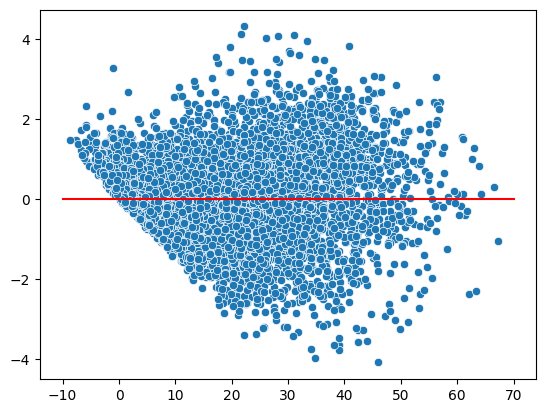

In [32]:
sns.scatterplot(x=model_forward.predict(data), y=standardize(model_forward.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

#### Independence of residuals

<BarContainer object of 21 artists>

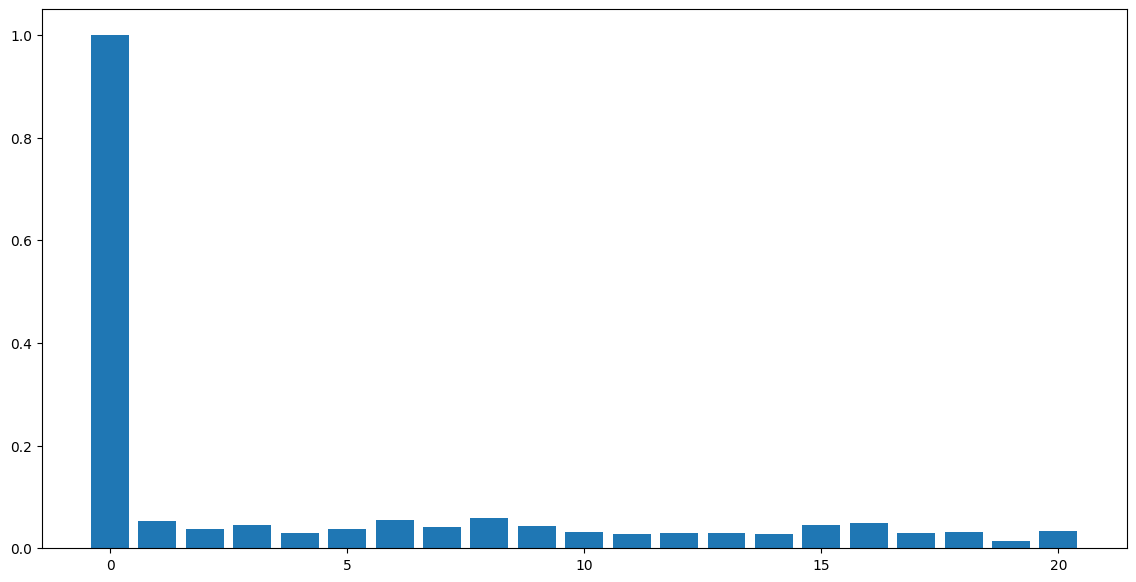

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_forward.resid, nlags=lags))

#### Normality of Residuals

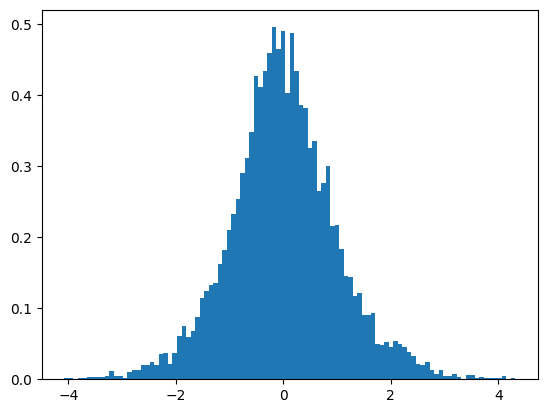

In [34]:
hide = plt.hist(standardize(model_forward.resid), bins=100, density=True)

In [35]:
residuals_pvalue = stats.shapiro(standardize(model_forward.resid)).pvalue
if residuals_pvalue < alpha:
    print("REJECT NULL:", residuals_pvalue ,"p-value")
else:
    print("FAIL TO REJECT NULL", residuals_pvalue ,"p-value")

REJECT NULL: 2.626869554907694e-20 p-value


C:\Users\nicks\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Completeness

In [36]:
...

Ellipsis

## Penalized Regression on All Variables
I think we have to do the regression assumptions for the entire data set

### Lasso Regression On Our Subset

In [51]:
lasso_model = smf.ols('Education ~ Poverty + Lead + Asthma + Linguistic_Isolation + Pollution_Burden', data).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=1.0)
print(lasso_model.params[lasso_model.params > 1e-2])

Poverty                 0.323336
Lead                    0.112123
Asthma                  0.020446
Linguistic_Isolation    0.580812
dtype: float64


### Lasso Regression On All (Non-Collinear) Variables 

In [47]:
all_variables = data.columns
updated_variables = list(set(new_columns) - set(['Education']))


full_model_formula = 'Education ~ ' + ' + '.join(updated_variables)
full_model_formula
# variables removed: 'Education', and all variables not in New Columns.
# full_model_formula

'Education ~ Haz_Waste + Latitude + Ozone + California_County + PM25 + Low_Birth_Weight + Linguistic_Isolation + ZIP + Total_Population + Groundwater_Threats + Housing_Burden + Diesel_PM + Cleanup_Sites + Unemployment + Tox_Release + Imp_Water_Bodies + Poverty + Census_Tract + Solid_Waste + Cardiovascular_Disease + Traffic + Asthma + Lead + Longitude + Pesticides + Drinking_Water + Approximate_Location'

In [48]:
full_lasso_model = smf.ols(full_model_formula, data).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=1.0)
print(full_lasso_model.params[full_lasso_model.params > 1e-2])

Intercept               1.669493
Haz_Waste               0.132102
Latitude                0.365068
PM25                    0.160960
Linguistic_Isolation    0.531341
Poverty                 0.387580
Asthma                  0.033628
Lead                    0.157313
Longitude               0.169874
dtype: float64


In [42]:
# forward_vars_cleaned = forward_vars_cleaned - {'CES_40_Score', 'CES_40_Percentile_Range'}
# true_model_formula = 'Education ~ ' + ' + '.join(forward_vars_cleaned)
# model_forward_cleaned = smf.ols(true_model_formula, data_copy).fit()
# model_forward_cleaned.summary()

### Elastic Net on Our Subset

In [50]:
elastic_net_model = smf.ols('Education ~ Poverty + Lead + Asthma + Linguistic_Isolation + Pollution_Burden', data).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=.5)
print(elastic_net_model.params[elastic_net_model.params > 1e-2])

Poverty                 0.326383
Lead                    0.112683
Asthma                  0.019684
Linguistic_Isolation    0.578014
dtype: float64


### Elastic Net Model On All (Non-Collinear) Variables

In [49]:
full_elastic_net_model = smf.ols(full_model_formula, data).fit_regularized(method='elastic_net', alpha=0.3, L1_wt=.5)
print(full_elastic_net_model.params[full_elastic_net_model.params > 1e-2])

Haz_Waste                 0.087082
Latitude                  0.426316
PM25                      0.231442
Low_Birth_Weight          0.143924
Linguistic_Isolation      0.528282
Imp_Water_Bodies          0.041209
Poverty                   0.376912
Cardiovascular_Disease    0.458183
Lead                      0.157254
Longitude                 0.195113
dtype: float64


It seems that lasso regression and elastic net regression both select the same variables.

### Regression Model Using Variables Selected by Lasso and Elastic

In [53]:
# selected_variables_lasso = ['Lead','Poverty','PM25_Pctl', 'Pesticides_Pctl', 'Cleanup_Sites', 'Pollution_Burden' , 'Pollution_Burden_Pctl' ,        
# 'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation', 'Linguistic_Isolation_Pctl', 'Pop_Char_','Pop_Char_Pctl']

# selected_variables_elastic = ['Lead','Poverty', 'PM25_Pctl', 'Pesticides_Pctl', 'Cleanup_Sites','Haz_Waste', 'Pollution_Burden','Pollution_Burden_Pctl',          
# 'Cardiovascular_Disease_Pctl', 'Linguistic_Isolation', 'Linguistic_Isolation_Pctl', 'Unemployment_Pctl', 'Pop_Char_', 'Pop_Char_Pctl']

selected_variables_lasso = ['Haz_Waste', 'Latitude', 'PM25', 'Linguistic_Isolation', 'Poverty', 'Asthma', 'Lead', 'Longitude']
selected_variables_elastic = ['Haz_Waste', 'Latitude', 'PM25', 'Low_Birth_Weight', 'Linguistic_Isolation', 'Imp_Water_Bodies', 'Poverty', 'Cardiovascular_Disease', 'Lead', 'Longitude']   

In [54]:
selected_variables_lasso == selected_variables_elastic

False

The variables returned by selected lasso and elastic net are different

In [55]:
lasso_formula = 'Education ~ ' + ' + '.join(selected_variables_lasso)
elastic_formula = 'Education ~ ' + ' + '.join(selected_variables_elastic)

In [56]:
model_lasso = smf.ols(lasso_formula, data).fit()
model_lasso.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     2939.
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:38:33   Log-Likelihood:                -26129.
No. Observations:                7672   AIC:                         5.228e+04
Df Residuals:                    7663   BIC:                         5.234e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               31.5896     12.136      2.603      0.009       7.800      55.379
Haz_Waste                0.1628      0.059      2.742      0.006       0.046       0.279
Latitude                -0.1938      0.126     -1.537      0.124      -0.441       0.053
PM25                     0.0586      0.048      1.217      0.224      -0.036       0.153
Linguistic_Isolation     0.5342      0.012     45.427      0.000       0.511       0.557
Poverty                  0.3325      0.008     43.923      0.000       0.318       0.347
Asthma                   0.0434      0.003     12.709      0.000       0.037       0.050
Lead                     0.1290      0.005     25.910      0.000       0.119       0.139
Longitude                0.2686      0.134      2.000      0.046       0.005       0.532
==============================================================================
Omnibus:                      200.317   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.743
Skew:                           0.129   Prob(JB):                     1.45e-95
Kurtosis:                       4.140   Cond. No.                     2.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
model_elastic = smf.ols(elastic_formula, data).fit()
model_elastic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     2554.
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:39:05   Log-Likelihood:                -25530.
No. Observations:                7573   AIC:                         5.108e+04
Df Residuals:                    7562   BIC:                         5.116e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -62.8714     12.821     -4.904      0.000     -88.004     -37.739
Haz_Waste                  0.1601      0.058      2.770      0.006       0.047       0.273
Latitude                  -1.0777      0.135     -8.004      0.000      -1.342      -0.814
PM25                      -0.0278      0.049     -0.573      0.567      -0.123       0.067
Low_Birth_Weight           0.0338      0.055      0.612      0.541      -0.075       0.142
Linguistic_Isolation       0.5309      0.011     46.790      0.000       0.509       0.553
Imp_Water_Bodies           0.0115      0.017      0.657      0.511      -0.023       0.046
Poverty                    0.3170      0.007     42.512      0.000       0.302       0.332
Cardiovascular_Disease     0.4938      0.020     25.042      0.000       0.455       0.533
Lead                       0.1278      0.005     26.539      0.000       0.118       0.137
Longitude                 -0.7591      0.143     -5.306      0.000      -1.039      -0.479
==============================================================================
Omnibus:                      204.080   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              460.879
Skew:                           0.119   Prob(JB):                    8.34e-101
Kurtosis:                       4.185   Cond. No.                     2.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Assumptions for Lasso

### Independence

<BarContainer object of 21 artists>

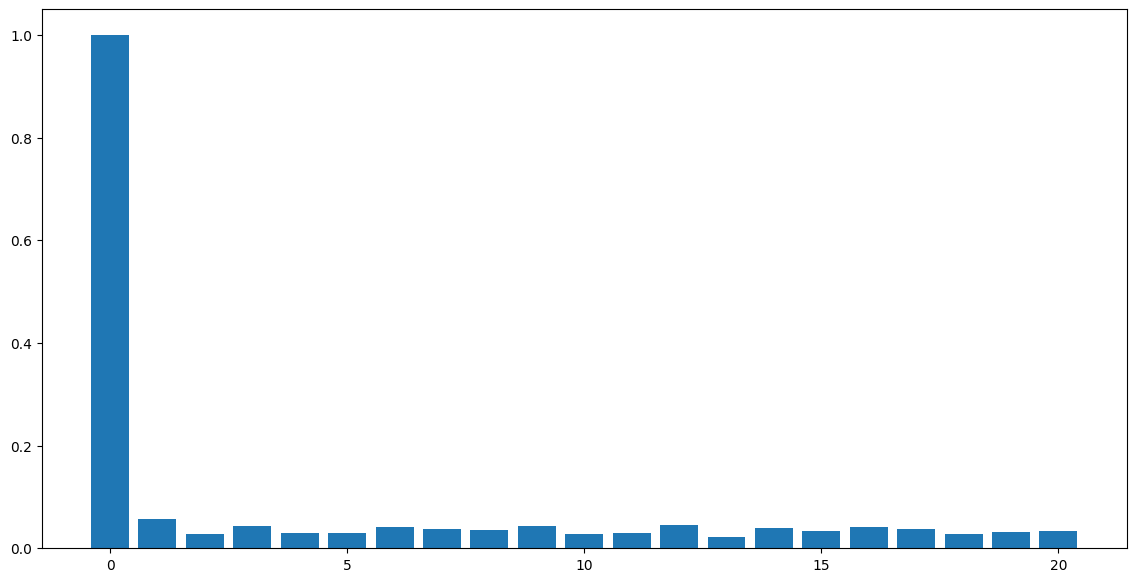

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_lasso.resid, nlags=lags))

### Linearity & Heteroscadiscity

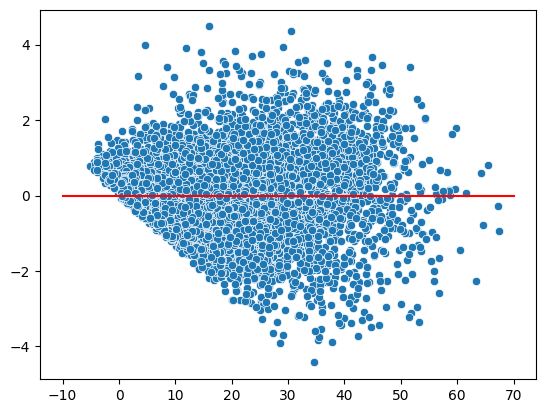

In [60]:
sns.scatterplot(x=model_lasso.predict(data[selected_variables_lasso]), y=standardize(model_lasso.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

### Normality of Residuals

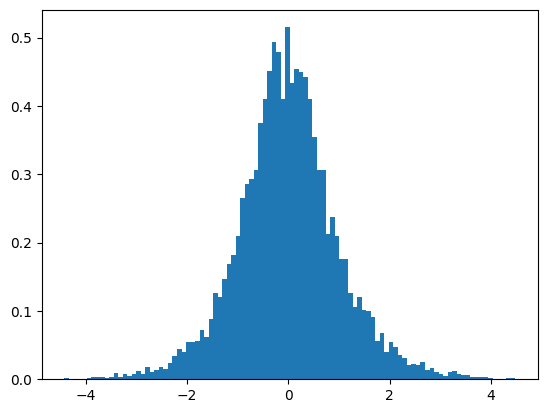

In [61]:
hide = plt.hist(standardize(model_lasso.resid), bins=100, density=True)

## Regression Assumptions for Elastic

### Independence

<BarContainer object of 21 artists>

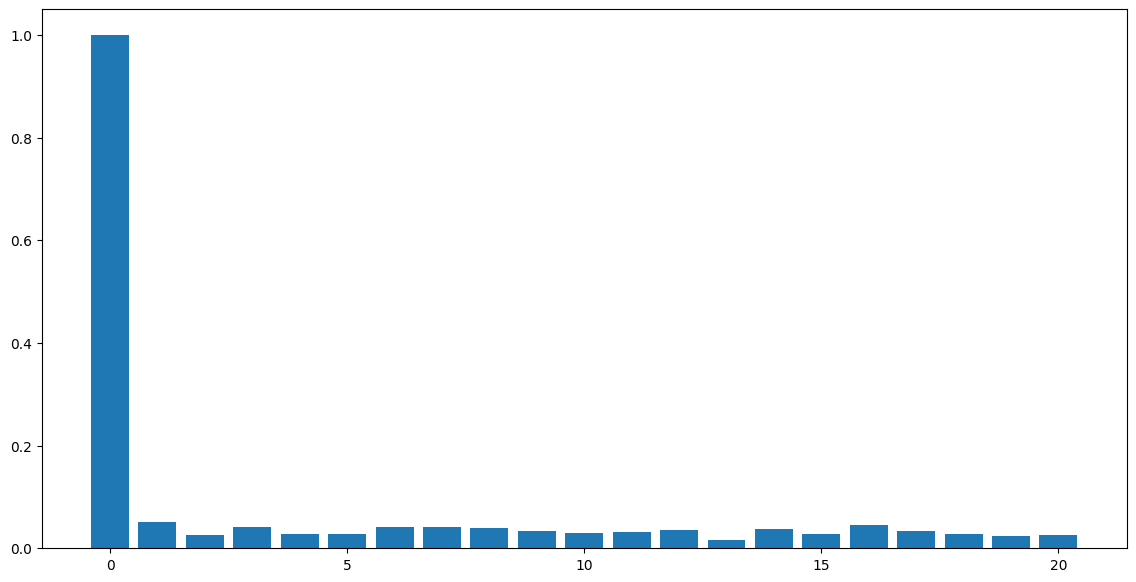

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_elastic.resid, nlags=lags))

### Linearity & Homoscadiscity

<Axes: >

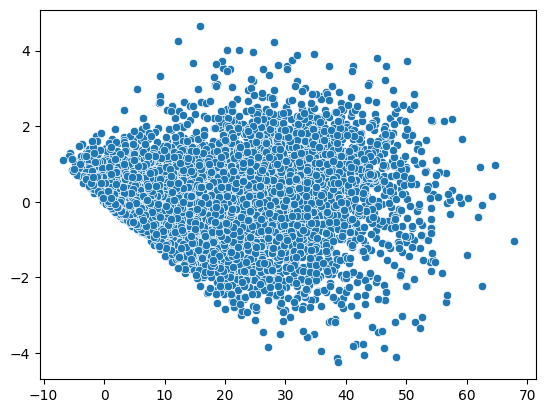

In [63]:
sns.scatterplot(x=model_elastic.predict(data[selected_variables_elastic]), y=standardize(model_elastic.resid))

### Normality of Residuals

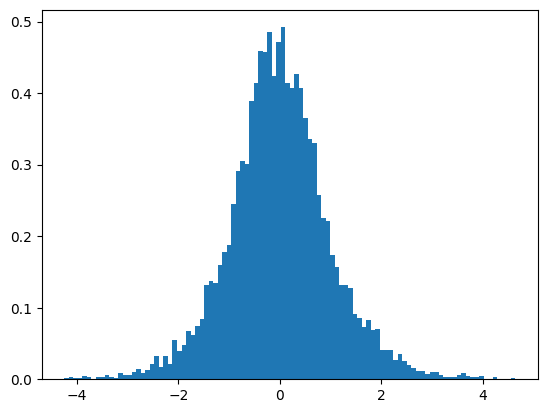

In [64]:
hide = plt.hist(standardize(model_elastic.resid), bins=100, density=True)

Given the model's complexity's are relatively similar, it is expected to see that they both perform the same in terms of meeting the regression assumptions.

# NEWEST MODEL: FINAL HURRAH

In [68]:
common_variables = set(selected_variables_lasso).intersection(set(selected_variables_elastic))
newest_string = 'Education ~ ' + ' + '.join(common_variables)

model_newest = smf.ols(newest_string, data).fit()
model_newest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Education   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     3267.
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:45:56   Log-Likelihood:                -26209.
No. Observations:                7672   AIC:                         5.243e+04
Df Residuals:                    7664   BIC:                         5.249e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               29.5178     12.261      2.407      0.016       5.482      53.553
Haz_Waste                0.1885      0.060      3.142      0.002       0.071       0.306
Latitude                -0.0068      0.127     -0.054      0.957      -0.255       0.241
PM25                     0.1268      0.048      2.625      0.009       0.032       0.222
Poverty                  0.3669      0.007     51.356      0.000       0.353       0.381
Linguistic_Isolation     0.5089      0.012     43.457      0.000       0.486       0.532
Lead                     0.1415      0.005     28.692      0.000       0.132       0.151
Longitude                0.3060      0.136      2.255      0.024       0.040       0.572
==============================================================================
Omnibus:                      189.849   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.335
Skew:                           0.074   Prob(JB):                     2.94e-95
Kurtosis:                       4.158   Cond. No.                     2.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Newest Model - Regression Assumptions

### Linearity and Homoedasticity

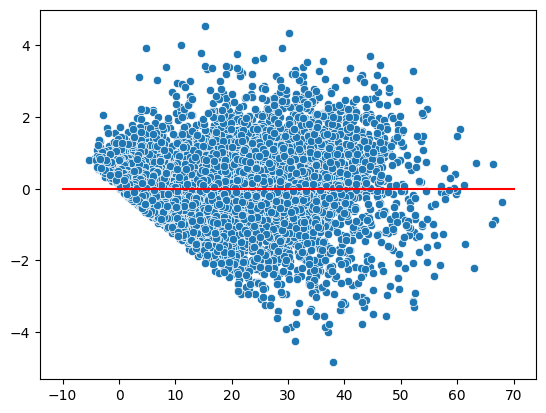

In [69]:
sns.scatterplot(x=model_newest.fittedvalues, y=standardize(model_newest.resid))
plt.plot(np.linspace(-10, 70, 3), [0, 0, 0], 'r')

### Independence

<BarContainer object of 21 artists>

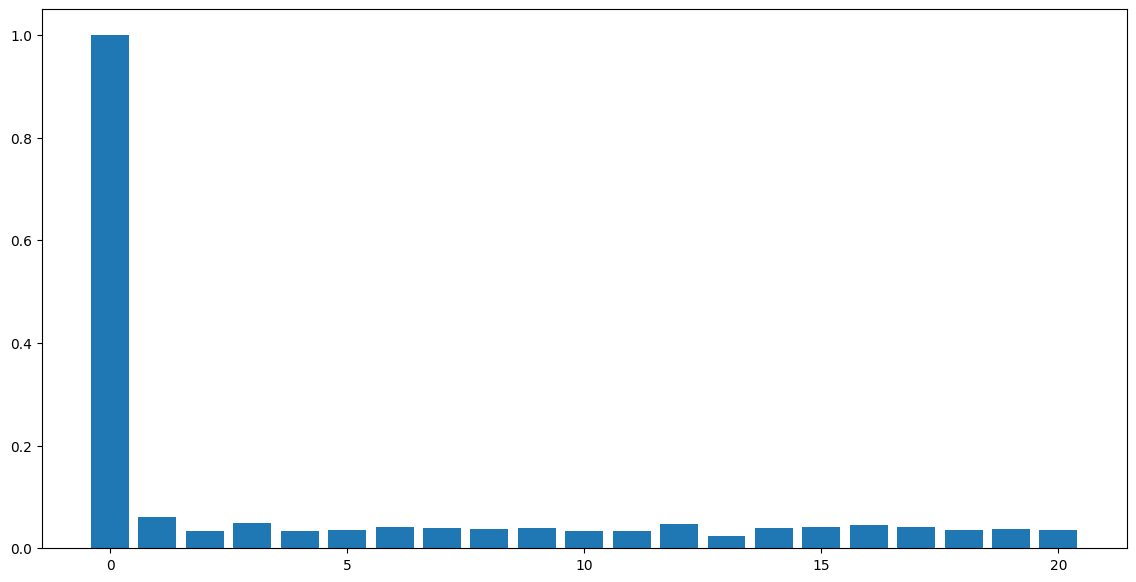

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

lags = 20
ax.bar(range(lags+1), acf(model_newest.resid, nlags=lags))

### Normality

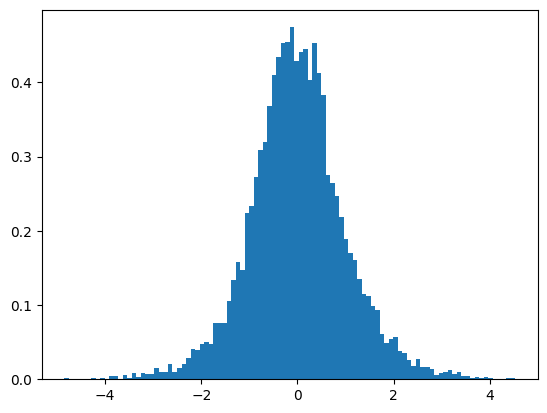

In [71]:
hide = plt.hist(standardize(model_newest.resid), bins=100, density=True)

In [72]:
residuals_pvalue = stats.shapiro(standardize(model_newest.resid)).pvalue
if residuals_pvalue < alpha:
    print("REJECT NULL:", residuals_pvalue ,"p-value")
else:
    print("FAIL TO REJECT NULL", residuals_pvalue ,"p-value")

REJECT NULL: 2.8318535086511124e-23 p-value


C:\Users\nicks\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Newest Model - Correlation Heatmap

<Axes: >

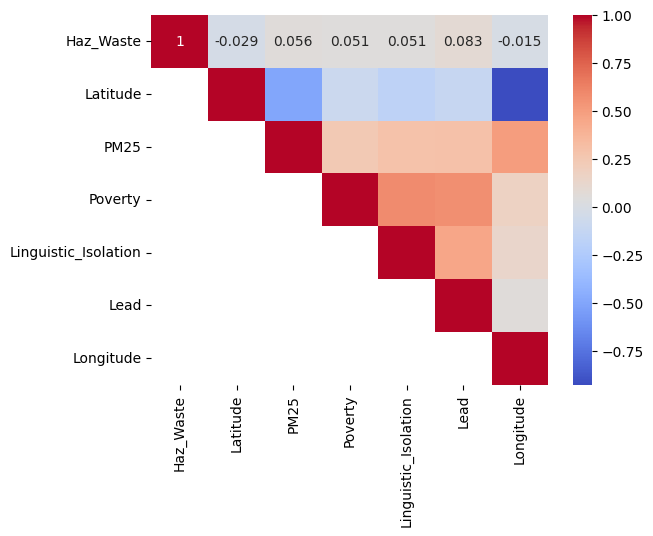

In [80]:
corr_table = data[list(common_variables)].corr() 
sns.heatmap(corr_table, annot=True, cmap='coolwarm', mask=np.tril(corr_table, k=-1))

## Newest Model - Log of Response

In [101]:
model_newest_data = data.copy()
for col in common_variables:
    model_newest_data = model_newest_data[(~model_newest_data[col].isna())]
model_newest_data = model_newest_data[(~model_newest_data['Education'].isna()) & (model_newest_data['Education'] > 0)]

In [104]:
common_variables = set(selected_variables_lasso).intersection(set(selected_variables_elastic))
lognewest_string = 'np.log(Education) ~ ' + ' + '.join(common_variables)

model_lognewest = smf.ols(newest_string, model_newest_data).fit()
model_lognewest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(Education)   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1876.
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:10:59   Log-Likelihood:                -7214.6
No. Observations:                7646   AIC:                         1.445e+04
Df Residuals:                    7638   BIC:                         1.450e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.2368      1.036      9.881      0.000       8.206      12.268
Haz_Waste                0.0101      0.005      1.988      0.047       0.000       0.020
Latitude                 0.0800      0.011      7.486      0.000       0.059       0.101
PM25                     0.0081      0.004      1.995      0.046       0.000       0.016
Poverty                  0.0255      0.001     42.199      0.000       0.024       0.027
Linguistic_Isolation     0.0252      0.001     25.476      0.000       0.023       0.027
Lead                     0.0100      0.000     24.038      0.000       0.009       0.011
Longitude                0.1027      0.011      8.957      0.000       0.080       0.125
==============================================================================
Omnibus:                     1336.788   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2975.308
Skew:                          -1.012   Prob(JB):                         0.00
Kurtosis:                       5.289   Cond. No.                     2.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

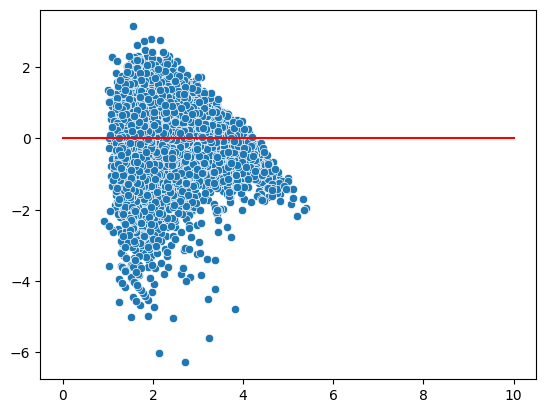

In [109]:
# NOT A GOOD FIT
sns.scatterplot(x=model_lognewest.fittedvalues, y=standardize(model_lognewest.resid))
plt.plot(np.linspace(-0, 10, 3), [0, 0, 0], 'r')

### Newest Model - Interaction Terms

In [ ]:
# I NEED TO DO THIS